## 提高神经网络的性能
**学习目标**：
- 根据我们学习到的「最佳实践」来提高神经网络的表现。

值得注意的是，本节所学到的优化方法不针对于神经网络，这些方法可以改进大多数类型的模型。

### 设置¶
加载加州住房数据集。

In [1]:
from __future__ import print_function

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_df = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv",
                                   sep=',')
california_housing_df = california_housing_df.reindex(np.random.permutation(california_housing_df.index))

/Users/kevin/.virtualenvs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# 预处理特征
def preprocess_features(california_housing_df):
    """预处理房价的DataFrame，准备输入特征,添加人为特征
    Args:
        california_housing_df: 包含加州房价数据的df
    Returns:
        包含处理后特征的DataFrame
    """
    selected_features = california_housing_df[["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
    processed_features = selected_features.copy()
    # 创建额外的特征
    processed_features["rooms_per_person"] = (california_housing_df["total_rooms"] / california_housing_df["population"])
    return processed_features

# 预处理目标
def preprocess_targets(california_housing_df):
    """从加州房价DataFrame准备目标特征，即标签
    Args:
        california_housing_dataframe: 包含加州房价数据的df
    Returns:
        包含目标标签的df
    """
    output_targets = pd.DataFrame()
    # 将目标标签的值缩放
    output_targets["median_house_value"] = (california_housing_df["median_house_value"] / 1000.0)
    return output_targets


In [3]:

# 选择前12000/17000用于训练
training_examples = preprocess_features(california_housing_df.head(12000))
training_targets = preprocess_targets(california_housing_df.head(12000))

# 选择最后的5000用于验证
validation_examples = preprocess_features(california_housing_df.tail(5000))
validation_targets = preprocess_targets(california_housing_df.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2656.6,542.7,1440.8,505.0,3.9,2.0
std,2.1,2.0,12.6,2169.6,425.4,1169.0,389.1,1.9,1.2
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1468.8,299.0,794.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2130.0,435.0,1173.0,410.0,3.6,1.9
75%,37.7,-118.0,37.0,3185.2,652.0,1736.2,608.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.7,2612.5,531.6,1402.6,492.1,3.9,2.0
std,2.2,2.0,12.7,2204.4,411.9,1095.1,373.2,1.9,1.2
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1441.0,293.0,777.0,277.0,2.5,1.5
50%,34.3,-118.5,29.0,2121.5,431.0,1151.0,405.5,3.5,1.9
75%,37.7,-118.0,37.0,3080.2,641.2,1694.0,597.0,4.7,2.3
max,41.9,-114.6,52.0,37937.0,5471.0,16122.0,5189.0,15.0,41.3


Training targets summary:


,median_house_value
count,12000.0
mean,207.4
std,115.1
min,15.0
25%,120.3
50%,181.1
75%,265.9
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,207.0
std,118.0
min,15.0
25%,118.3
50%,177.8
75%,263.1
max,500.0


### 构建神经网络
使用DNNRegressor类定义。

使用hidden_units定义网络结构，是一个整数列表，每一个整数对应一个隐藏层，数值表示节点数。

默认情况下，所有隐藏层使用ReLU激活函数，且层间全连接。

In [4]:
def my_input_fn(features, targets, batch_size=1,shuffle=True, num_epochs=None):
    """使用多个特征训练一个线性回归器
    Args:
        features: 特征的DataFrame
        targets: 目标的DataFrame
        batch_size: 传递给模型的批大小
        shuffle: 是否打乱数据
        num_epochs: 数据重复的epochs数
    Returns:
        下一批数据元组(features, labels)
    """
    # 转换DataFrame到numpy数组
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    # 构建数据集
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # 打乱数据
    if shuffle:
        ds = ds.shuffle(10000)
        
    # 返回下一批数据
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [5]:
def construct_feature_columns(input_features):
    """构建特征列
    Args:
        input_features: 数值特征的名字
    Returns:
        特征列集
    """
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [28]:
def train_nn_regression_model(
                my_optimizer, 
                steps, 
                batch_size,
                hidden_units,
                feature_columns,
                training_examples, 
                training_targets, 
                validation_examples, 
                validation_targets):
    """使用多个特征训练一个线性回归模型
    """
    periods = 10
    steps_per_period = steps / periods
    
    # 定义优化器
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    # 创建一个线性回归器
    dnn_regressor = tf.estimator.DNNRegressor(feature_columns=feature_columns, 
                                                    hidden_units=hidden_units,
                                                    optimizer=my_optimizer)
    
    # 创建输入函数
    training_input_fn = lambda: my_input_fn(training_examples,training_targets["median_house_value"], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"], num_epochs=1, shuffle=False)
    
    # 训练模型，并在每个周期输出loss
    print("Start training...")
    print("RMSE (on training data): ")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        dnn_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
        
        # 计算预测
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])
        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])
        
        # 计算训练和验证的损失
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        # 输出结果
        print("period %02d : %.2f" % (period, training_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished!")
    
    # 损失随周期变化图
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error via Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validaiton")
    plt.legend()
    
    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)
    
    return dnn_regressor, training_rmse, validation_rmse

Start training...
RMSE (on training data): 
period 00 : 157.81
period 01 : 142.82
period 02 : 128.01
period 03 : 113.46
period 04 : 107.17
period 05 : 104.65
period 06 : 103.57
period 07 : 103.22
period 08 : 102.16
period 09 : 102.16
Model training finished!
Final RMSE (on training data):   102.16
Final RMSE (on validation data): 102.56


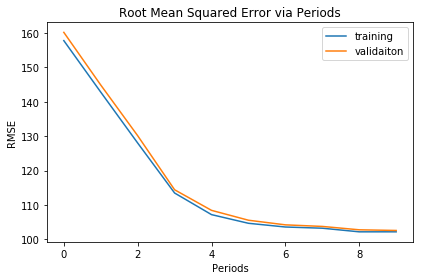

In [21]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### 任务1. 使用线性缩放将特征标准化
把输入标准化到(-1, 1)之间, 是一种良好的标准做法。这样一来，SGD在一个维度中采用很大的步长，或在另一维度采用很小步长时不会受阻。

**注意**：一般来说，当输入特征大致处在相同的范围时，神经网络的训练效果最好。


In [13]:
# 线性缩放
def linear_scale(series):
    min_val = series.min()
    max_val = series.max()
    scale = (max_val-min_val) / 2.0
    return series.apply(lambda x: ((x - min_val) / scale) - 1.0)

In [22]:
# 标准化线性缩放
def normalize_linear_scale(examples_dataframe):
    """
    Returns: 返回所有特征都被标准化的DataFrame
    """
    processed_features = pd.DataFrame()
    processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
    processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
    processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
    processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
    processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
    processed_features["population"] = linear_scale(examples_dataframe["population"])
    processed_features["households"] = linear_scale(examples_dataframe["households"])
    processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
    processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
    return processed_features

Start training...
RMSE (on training data): 
period 00 : 162.15
period 01 : 113.53
period 02 : 101.85
period 03 : 86.19
period 04 : 77.03
period 05 : 74.08
period 06 : 72.59
period 07 : 71.64
period 08 : 70.87
period 09 : 70.42
Model training finished!
Final RMSE (on training data):   70.42
Final RMSE (on validation data): 71.92


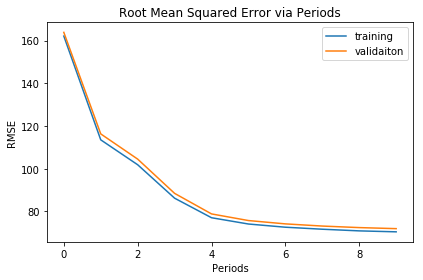

In [23]:
normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_df))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    feature_columns=construct_feature_columns(normalized_training_examples),
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### 任务2. 尝试别的优化器
使用AdaGRad 和 Adam优化器并对比效果。

> AdaGrad 优化器是一种备选方案。AdaGrad 的**核心**是灵活地修改模型中每个系数的学习率，从而单调降低有效的学习率。该优化器对于**凸优化问题**非常有效，但**不一定适合非凸优化问题**的神经网络训练。我们可以通过指定 ```tf.train.AdagradOptimizer```来使用 AdaGrad。
>
> 请注意，对于 AdaGrad，我们可能需要使用**较大的学习率**。

> 对于**非凸优化问题**，Adam 有时比 AdaGrad 更有效。要使用 Adam，请调用 ```tf.train.AdamOptimizer``` 方法。此方法将几个可选超参数作为参数，但我们的解决方案仅指定其中一个 (learning_rate)。
>
> 在应用设置中，我们应该谨慎指定和调整可选超参数。

Start training...
RMSE (on training data): 
period 00 : 79.31
period 01 : 72.82
period 02 : 74.06
period 03 : 70.18
period 04 : 69.52
period 05 : 68.61
period 06 : 68.75
period 07 : 68.83
period 08 : 70.53
period 09 : 67.61
Model training finished!
Final RMSE (on training data):   67.61
Final RMSE (on validation data): 68.37


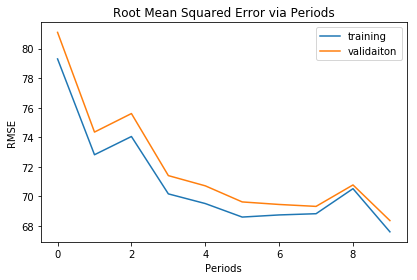

In [30]:
# AdaGrad优化器
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    feature_columns=construct_feature_columns(normalized_training_examples),
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)


Start training...
RMSE (on training data): 
period 00 : 221.16
period 01 : 129.14
period 02 : 114.52
period 03 : 105.74
period 04 : 90.63
period 05 : 76.07
period 06 : 71.21
period 07 : 70.55
period 08 : 70.26
period 09 : 69.59
Model training finished!
Final RMSE (on training data):   69.59
Final RMSE (on validation data): 70.67


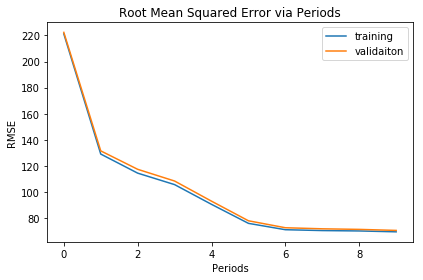

In [31]:
# Adam优化器
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    feature_columns=construct_feature_columns(normalized_training_examples),
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

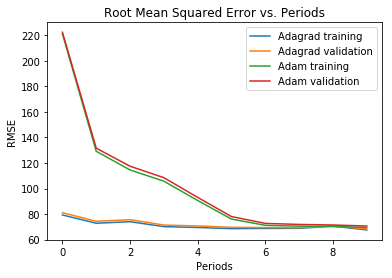

In [32]:
# 画图对比输出结果
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

### 任务3.尝试别的标准化方法
- 尝试对各种特征使用别的标准化方法，进一步提高性能。

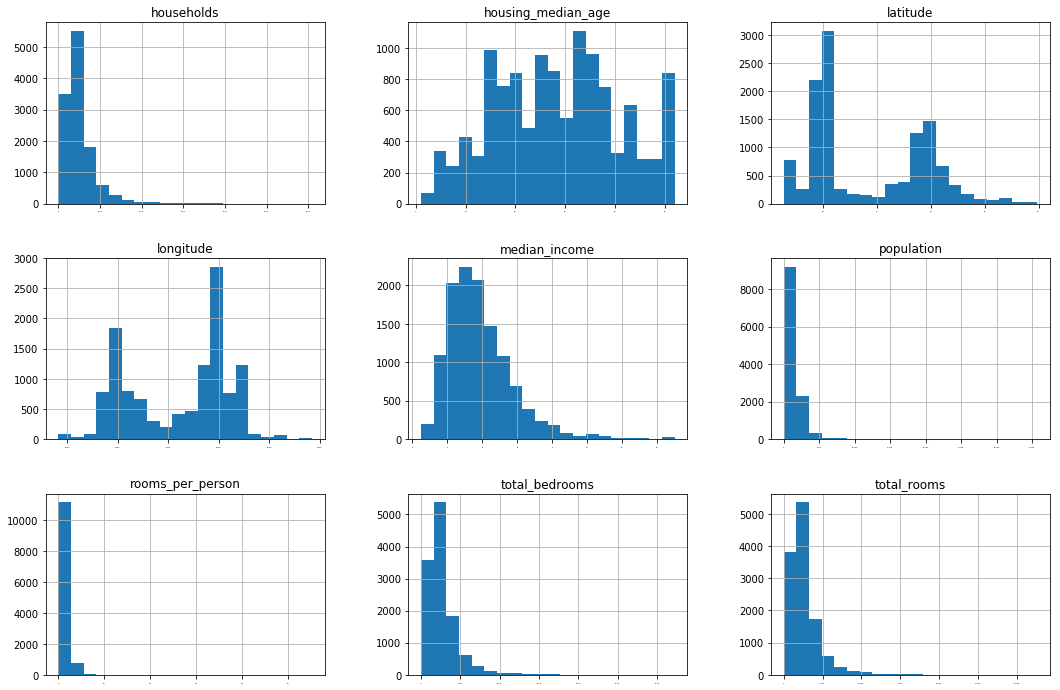

In [34]:
_ = training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=2)

从上面的绘图我们可以发现，大量的特征线性缩放后，中位数集中在了靠近-1的位置(-0.8)

我们应该考虑对不同的特征使用不同的标准化方式，例如**对数缩放**，**截取极端离群值**等。

In [35]:
# log缩放
def log_normalize(series):
    return series.apply(lambda x:math.log(x+1.0))

# 截取极端值
def clip(series, clip_to_min, clip_to_max):
    return series.apply(lambda x:(min(max(x, clip_to_min), clip_to_max)))

# z-score标准化
def z_score_normalize(series):
    mean = series.mean()
    std_dv = series.std()
    return series.apply(lambda x:(x - mean) / std_dv)

# 阈值二值化
def binary_threshold(series, threshold):
    return series.apply(lambda x:(1 if x > threshold else 0))

In [39]:
def my_normalization(examples_dataframe):
    """
    Returns: 特征标准化后的DataFrame
    """
    processed_features = pd.DataFrame()
    # households、median_income 和 total_bedrooms 在对数空间内均呈现为正态分布
    processed_features["households"] = log_normalize(examples_dataframe["households"])
    processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
    processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])

    # latitude、longitude 和 housing_median_age 像之前一样进行线性缩放，效果可能会更好
    processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
    processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
    processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

    # population、totalRooms 和 rooms_per_person 具有几个极端离群值,我们考虑截断
    processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
    processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
    processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))
    
    return processed_features

Start training...
RMSE (on training data): 
period 00 : 86.44
period 01 : 74.21
period 02 : 72.04
period 03 : 71.31
period 04 : 69.98
period 05 : 70.17
period 06 : 70.46
period 07 : 68.63
period 08 : 67.90
period 09 : 67.99
Model training finished!
Final RMSE (on training data):   67.99
Final RMSE (on validation data): 67.99


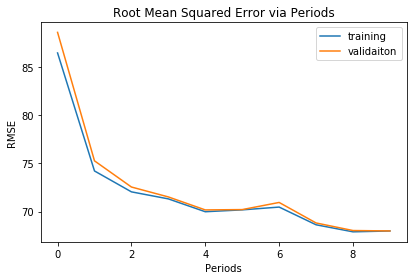

In [40]:
normalized_dataframe = my_normalization(preprocess_features(california_housing_df))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.15),
    steps=1000,
    batch_size=50,
    hidden_units=[10, 10],
    feature_columns=construct_feature_columns(normalized_training_examples),
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### 任务4.仅使用经度和纬度来预测房价
> 房地产商喜欢说，地段是房价的唯一重要特征。

我们可以通过仅使用经度和纬度作为输入特征来构建神经网络验证这一点。


In [41]:
def location_features(examples_dataframe):
    """
    Returns: 
        仅包括经度和纬度(longitude and latitude)特征的DataFrame
    """
    processed_features = pd.DataFrame()
    processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
    processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
    return processed_features

Start training...
RMSE (on training data): 
period 00 : 236.65
period 01 : 236.09
period 02 : 155.78
period 03 : 108.10
period 04 : 105.94
period 05 : 103.03
period 06 : 101.48
period 07 : 100.71
period 08 : 100.03
period 09 : 99.61
Model training finished!
Final RMSE (on training data):   99.61
Final RMSE (on validation data): 101.68


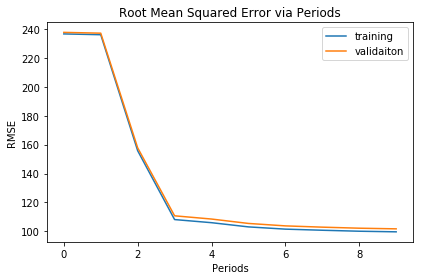

In [44]:
location_df = location_features(preprocess_features(california_housing_df))
location_training_examples = location_df.head(12000)
location_validation_examples = location_df.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=500,
    batch_size=50,
    hidden_units=[10,10,5,5,5],
    feature_columns=construct_feature_columns(location_training_examples),
    training_examples=location_training_examples,
    training_targets=training_targets,
    validation_examples=location_validation_examples,
    validation_targets=validation_targets)

**值得注意的是**，虽然我们只使用了两个特征，但是我们仍然取得了较之前的线性回归模型更好的结果，而且房价在更短距离上也可能有较大差异。